In [62]:
%matplotlib inline  
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# plt.ioff()

In [63]:
titanic = pd.read_csv('titanic_data.csv', index_col=0, parse_dates=True)

In [64]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [65]:
# remove rows with missing Age info
titanic = titanic[np.isnan(titanic['Age']) == False]

# remove columns that are not useful to analysis
titanic.drop(['Cabin', 'Name', 'Ticket'], axis = 1, inplace = True)

In [66]:
# remove rows with missing Embarked info
titanic = titanic[pd.isnull(titanic['Embarked']) == False]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe54dbf6128>,
      dtype=object)

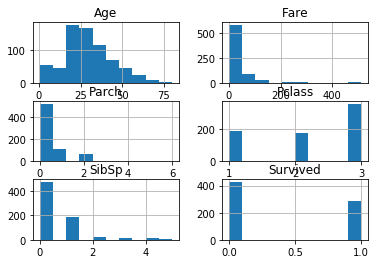

In [67]:
titanic.hist()

Survived
0    [[AxesSubplot(0.125,0.670278;0.336957x0.209722...
1    [[AxesSubplot(0.125,0.670278;0.336957x0.209722...
dtype: object

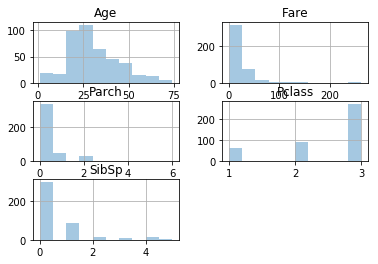

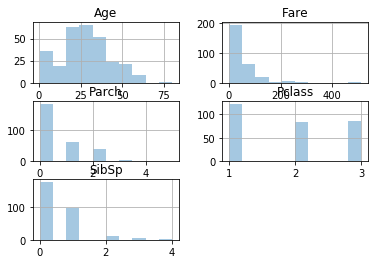

In [41]:
titanic.groupby('Survived').hist(alpha=0.4)

In [13]:
titanic['Sex_bool'] = titanic['Sex'] == 'male'
titanic.corr()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_bool
Survived,1.000000,-0.338481,-0.077221,-0.035322,0.081629,0.257307,-0.543351
Pclass,-0.338481,1.000000,-0.369226,0.083081,0.018443,-0.549500,0.131900
Age,-0.077221,-0.369226,1.000000,-0.308247,-0.189119,0.096067,0.093254
SibSp,-0.035322,0.083081,-0.308247,1.000000,0.414838,0.159651,-0.114631
Parch,0.081629,0.018443,-0.189119,0.414838,1.000000,0.216225,-0.245489
Fare,0.257307,-0.549500,0.096067,0.159651,0.216225,1.000000,-0.182333
Sex_bool,-0.543351,0.131900,0.093254,-0.114631,-0.245489,-0.182333,1.000000


In [14]:
# Manual calculations
def standardize(series):
    return (series - series.mean()) / series.std(ddof=0)
def corr(x, y):
    return (standardize(x) * standardize(y)).mean()
r = corr(titanic['Pclass'], titanic['Survived'])
print(r)

-0.33848103596101325


In [15]:
import math
rows_count, columns_count = titanic.shape
def t_score_from_r(r, N):
    return math.sqrt((N-2)/(1-r**2)) * r
t_score_from_r(r, rows_count)

-10.725263268949398

In [84]:
survived = titanic[titanic['Survived'] == 1]
dead = titanic[titanic['Survived'] == 0]

In [17]:
def t_score(x, y):
    pooled_variance = (x.std(ddof=0)**2 * len(x) + y.std(ddof=0)**2 * len(y)) / (len(x)+len(y)-2)
    se = math.sqrt(pooled_variance/len(x) + pooled_variance/len(y))
    return (x.mean() - y.mean()) / se
t_score(survived['Pclass'], dead['Pclass'])

-10.725263268949513

In [18]:
# survived_sex_count = titanic.groupby(['Survived', 'Sex_bool']).count()['Pclass']
# print(survived_sex_count)
contingency = pd.crosstab(
    titanic['Sex'],
    titanic['Survived'],
    margins=True
)
contingency

Survived,0,1,All
Sex,,,
female,81,233,314
male,468,109,577
All,549,342,891


In [19]:
from functools import reduce
obs = np.array(list(reduce(lambda row1, row2: np.append(row1[0:-1], row2[0:-1]), contingency[0:-1].values)))
row_sums = contingency.values[0:-1,-1]
col_sums = contingency.values[-1,0:-1]
total = float(contingency.loc['All', 'All'])

expected = []
for row_v in row_sums:
    for col_v in col_sums:
        expected.append(row_v*col_v/total)    
expected = np.array(expected)
        
chi_squared = ((obs - expected)**2/expected).sum()
print(f'Chi-square: {chi_squared}')
dof = (len(row_sums)-1)*(len(col_sums)-1)
print(f'dF: {dof}')

Chi-square: 263.05057407065567
dF: 1


In [20]:
from scipy import stats
obs_table = np.array(list(map(lambda row: row[0:-1], contingency.values[0:-1])))
stats.chi2_contingency(obs_table)

(260.71702016732104,
 1.1973570627755645e-58,
 1,
 array([[193.47474747, 120.52525253],
        [355.52525253, 221.47474747]]))

In [21]:
data = pd.DataFrame([[15,12,14,11],[39,45,48,60],[65,45,32,38]]).T
def sum_squares_from_mean(array):
    return sum((array - array.mean())**2)
def ss_within(data):
    return data.apply(sum_squares_from_mean).sum()
def ss_between(data):
    means = data.apply(np.mean)
    return sum_squares_from_mean(means) * data.shape[0]
def df_between(data): 
    return data.shape[1] - 1
def df_within(data):
    return (data.shape[0] - 1) * data.shape[1]
def ms_between(data):
    return ss_between(data) / df_between(data)
def ms_within(data):
    return ss_within(data) / df_within(data)
def f_score(data):
    return ms_between(data) / ms_within(data)
def eta_square(data):
    return ss_between(data) / (ss_between(data) + ss_within(data))
f_score(data)
eta_square(data)

0.7774143570321914

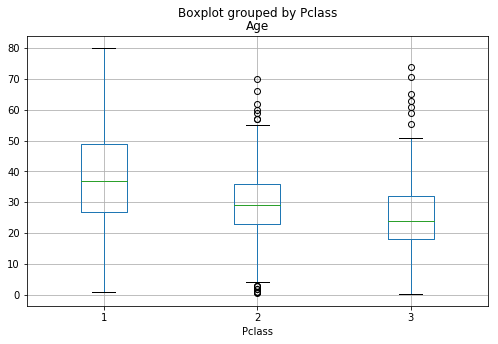

In [69]:
titanic.boxplot('Age', by='Pclass', figsize=(8,5))

In [70]:
N = titanic.shape[0]  # conditions times participants
n = titanic.groupby('Pclass').size() #Participants in each condition
n.values

array([184, 173, 355])

In [71]:
temp = titanic[~np.isnan(titanic['Age'])].groupby('Pclass')
ages = pd.DataFrame([temp.get_group(x)['Age'].values for x in temp.groups], index=[1,2,3])
ages.T

,1,2,3
0,38.0,14.00,22.0
1,35.0,55.00,26.0
2,54.0,35.00,35.0
3,58.0,34.00,2.0
4,28.0,66.00,27.0
5,19.0,27.00,4.0
6,40.0,3.00,20.0
7,28.0,29.00,39.0
8,42.0,21.00,14.0
9,49.0,5.00,2.0


Survived
 AxesSubplot(0.125,0.125;0.775x0.755) count    288.000000
mean       0.496528
std        0.732512
min        0.000000
50%        0.000000
max        4.000000
Name: SibSp, dtype: float64
Dead
 AxesSubplot(0.125,0.125;0.775x0.755) count    424.000000
mean       0.525943
std        1.044760
min        0.000000
50%        0.000000
max        5.000000
Name: SibSp, dtype: float64


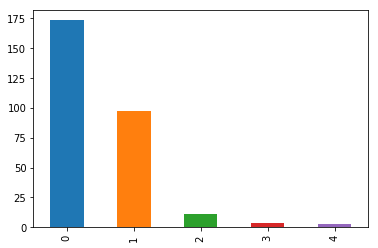

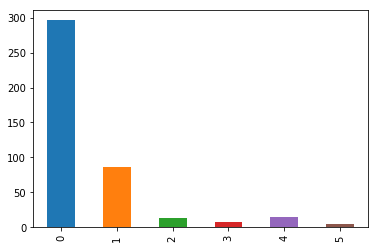

In [130]:
# print('Siblings')
# plt.figure()
# survived_sibsp = survived['SibSp']
# print('Survived\n', survived_sibsp.value_counts().plot.bar(), survived_sibsp.describe(percentiles=[]))
# print("---------------")
# plt.figure()
# dead_sibsp = dead['SibSp']
# print('Dead\n', dead_sibsp.value_counts().plot.bar(), dead_sibsp.describe(percentiles=[]))

groups = {'Survived': survived, 'Dead': dead }
def show_data_bar(attr):
    for name, data in groups.items():
        series = data[attr]
        plt.figure()
        sorted_index = series.value_counts().index.sort_values()
        print(f'{name}\n', series.value_counts().reindex(sorted_index).plot.bar(), series.describe(percentiles=[]))
show_data_bar('SibSp')

In [132]:
# # example
# df = pd.DataFrame({
#     'group': ['a', 'a', 'a', 'a', 'a', 'a', 'a', 
#               'b', 'b', 'b', 'b', 'b', 'b', 'b'],
#     'day': ['Mon', 'Tues', 'Fri', 'Thurs', 'Sat', 'Sun', 'Weds',
#             'Fri', 'Sun', 'Thurs', 'Sat', 'Weds', 'Mon', 'Tues'],
#     'amount': [1, 2, 4, 2, 1, 1, 2, 4, 5, 3, 4, 2, 1, 3]})

# weekdays = ['Mon', 'Tues', 'Weds', 'Thurs', 'Fri', 'Sat', 'Sun']
# mapping = {day: i for i, day in enumerate(weekdays)}
# mapping
# key = df['day'].map(mapping)
# key.argsort()
# df.iloc[key.argsort()].groupby(['group']).plot(kind='bar', x='day')

Survived
 AxesSubplot(0.125,0.125;0.775x0.755) count    288.000000
mean       0.531250
std        0.808747
min        0.000000
50%        0.000000
max        5.000000
Name: Parch, dtype: float64
Dead
 AxesSubplot(0.125,0.125;0.775x0.755) count    424.000000
mean       0.365566
std        0.878341
min        0.000000
50%        0.000000
max        6.000000
Name: Parch, dtype: float64


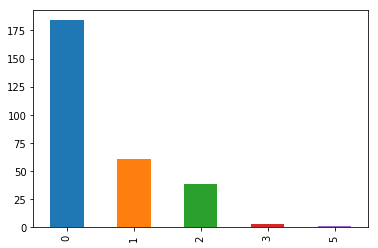

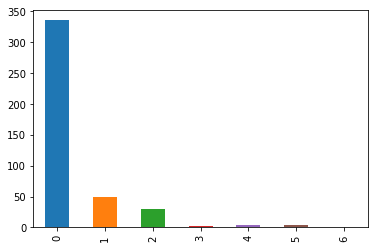

In [133]:
show_data_bar('Parch')

Survived
 AxesSubplot(0.125,0.125;0.775x0.755) count    288.000000
mean       1.878472
std        0.836340
min        1.000000
50%        2.000000
max        3.000000
Name: Pclass, dtype: float64
Dead
 AxesSubplot(0.125,0.125;0.775x0.755) count    424.000000
mean       2.485849
std        0.743633
min        1.000000
50%        3.000000
max        3.000000
Name: Pclass, dtype: float64


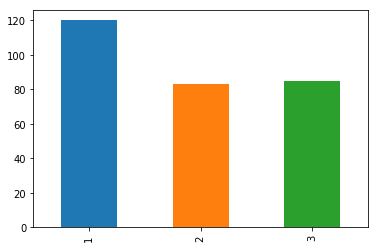

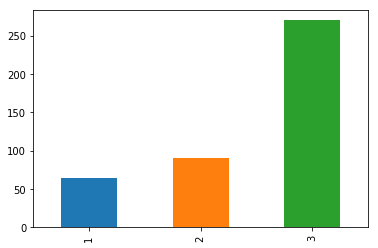

In [134]:
show_data_bar('Pclass')

Survived
 AxesSubplot(0.125,0.125;0.775x0.755) count        288
unique         2
top       female
freq         195
Name: Sex, dtype: object
Dead
 AxesSubplot(0.125,0.125;0.775x0.755) count      424
unique       2
top       male
freq       360
Name: Sex, dtype: object


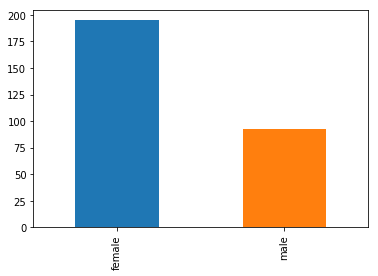

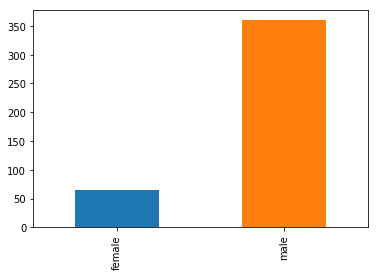

In [135]:
show_data_bar('Sex')

Survived
 AxesSubplot(0.125,0.125;0.775x0.755) count     288
unique      3
top         S
freq      201
Name: Embarked, dtype: object
Dead
 AxesSubplot(0.125,0.125;0.775x0.755) count     424
unique      3
top         S
freq      353
Name: Embarked, dtype: object


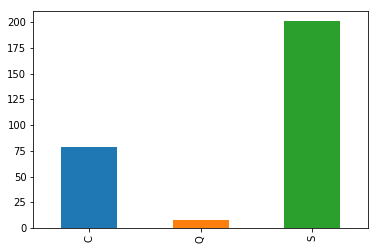

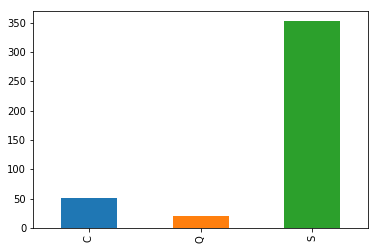

In [136]:
show_data_bar('Embarked')

Survived
 AxesSubplot(0.125,0.125;0.775x0.755) count    288.000000
mean      28.193299
std       14.859146
min        0.420000
50%       28.000000
max       80.000000
Name: Age, dtype: float64
Dead
 AxesSubplot(0.125,0.125;0.775x0.755) count    424.000000
mean      30.626179
std       14.172110
min        1.000000
50%       28.000000
max       74.000000
Name: Age, dtype: float64


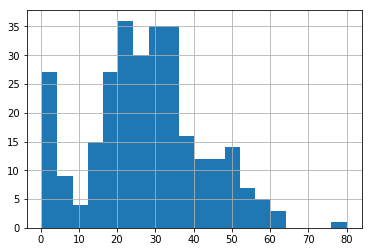

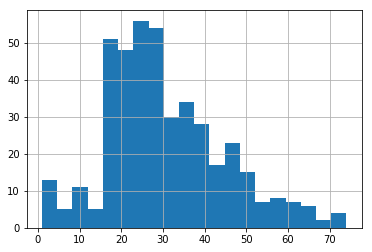

In [137]:
def show_data_hist(attr):
    for name, data in groups.items():
        series = data[attr]
        plt.figure()
        print(f'{name}\n', series.hist(bins=20), series.describe(percentiles=[]))
show_data_hist('Age')

Survived
 AxesSubplot(0.125,0.125;0.775x0.755) count    342.000000
mean      48.395408
std       66.596998
min        0.000000
50%       26.000000
max      512.329200
Name: Fare, dtype: float64
Dead
 AxesSubplot(0.125,0.125;0.775x0.755) count    549.000000
mean      22.117887
std       31.388207
min        0.000000
50%       10.500000
max      263.000000
Name: Fare, dtype: float64


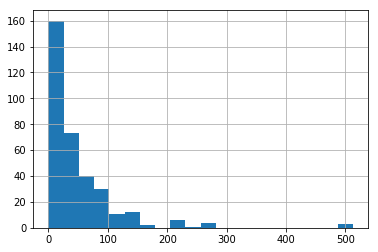

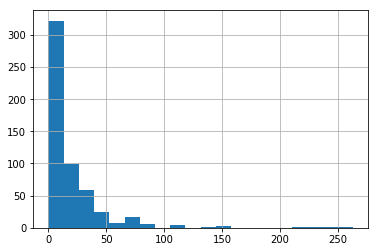

In [142]:
show_data_hist('Fare')